In [24]:
import pandas as pd
from graphdatascience import GraphDataScience # Load neo4j graph data science library
import os
import matplotlib.pyplot as plt

if os.getcwd().split('\\')[-1] == 'notebooks':
    os.chdir('..')

# Modeling
from flaml import AutoML
from sklearn.metrics import precision_score, recall_score, confusion_matrix

In [25]:
# Connect to a Neo4j instance (assumes local right now)
NEO4J_URI = os.environ.get("NEO4J_URI", "bolt://localhost:7687")
NEO4J_AUTH = None
NEO4J_DB = os.environ.get("NEO4J_DB", "neo4j")
if os.environ.get("NEO4J_USER") and os.environ.get("NEO4J_PASSWORD"):
    NEO4J_AUTH = (
        os.environ.get("NEO4J_USER"),
        os.environ.get("NEO4J_PASSWORD"),
    )
else:
    NEO4J_AUTH = ("neo4j", "Bookings")
gds = GraphDataScience(NEO4J_URI, auth=NEO4J_AUTH, database=NEO4J_DB)

### Build the training data by finding positive and negative examples of bookings

In [26]:
train_positive = gds.run_cypher("""
MATCH (p:Property)-[:TRAIN_BOOKING]->(w:Week)
RETURN DISTINCT
    p.id AS property_id
,   w.week_num AS week_num
,   w.week_degree AS week_degree
,   p.capacity AS capacity
,   p.pets_allowed AS pets_allowed
,   p.property_embedding AS property_embedding
,   1 AS is_booked
""")

In [27]:
# Find all properties that had did not have a booking in the current week, but had a booking in at least one of the previous two weeks
negative_weeks_ahead = gds.run_cypher("""
MATCH (p:Property)
MATCH (w:Week)
WHERE (p)-[:TRAIN_BOOKING]->()
MATCH (p)-[:TRAIN_BOOKING]->(:Week)-[:PRECEDES*1..4]->(w)
WHERE NOT (p)-[:TRAIN_BOOKING]->(w)
RETURN DISTINCT
    p.id AS property_id
,   w.week_num AS week_num
,   w.week_degree AS week_degree
,   p.capacity AS capacity
,   p.pets_allowed AS pets_allowed
,   p.property_embedding AS property_embedding
,   0 AS is_booked
""")

In [28]:
# Switch the order of the relationship in the second match
negative_weeks_behind = gds.run_cypher("""
MATCH (p:Property)
MATCH (w:Week)
WHERE (p)-[:TRAIN_BOOKING]->()
MATCH (p)-[:TRAIN_BOOKING]->(:Week)<-[:PRECEDES*1..4]-(w)
WHERE NOT (p)-[:TRAIN_BOOKING]->(w)
RETURN DISTINCT
    p.id AS property_id
,   w.week_num AS week_num
,   w.week_degree AS week_degree
,   p.capacity AS capacity
,   p.pets_allowed AS pets_allowed
,   p.property_embedding AS property_embedding
,   0 AS is_booked
""")

In [29]:
# Properties that were not booked on a given week where a totally different property was booked that week in the same city
negative_same_city_diff_attrs = gds.run_cypher("""
MATCH (p:Property)-[:LOCATED_IN]->(c:City)
MATCH (p)-[:HAS_TYPE]->(t:Type)
MATCH (w:Week)
WHERE (p)-[:TRAIN_BOOKING]->()
MATCH (c)<-[:LOCATED_IN]-(p2:Property)-[:TRAIN_BOOKING]->(w)
MATCH (p2)-[:HAS_TYPE]->(t2:Type)
WHERE NOT (p)-[:TRAIN_BOOKING]->(w)
    AND p2.capacity <> p.capacity
    AND p2.pets_allowed <> p.pets_allowed
    AND t2 <> t
RETURN DISTINCT
    p.id AS property_id
,   w.week_num AS week_num
,   w.week_degree AS week_degree
,   p.capacity AS capacity
,   p.pets_allowed AS pets_allowed
,   p.property_embedding AS property_embedding
,   0 AS is_booked
""")

In [30]:
# Import additional data sources from feature engineering
city_week_pref_attachment = pd.read_csv('Inputs/city_week_pref_attachment.csv')

In [31]:
# Get the property to city mapping
property_city_mapping = gds.run_cypher("""
MATCH (p:Property)-[:LOCATED_IN]->(c:City)
RETURN DISTINCT p.id AS property_id, c.name AS city
""")

In [32]:
# Combine the various datasets
train_data = pd.concat([train_positive, negative_weeks_ahead, negative_weeks_behind, negative_same_city_diff_attrs], axis = 0)

# Expand the property_embedding column into individual columns
p_embedding_cols = [f"property_embedding___{i + 1}" for i in range(len(train_data.iloc[0].property_embedding))]
train_data[p_embedding_cols] = train_data['property_embedding'].apply(pd.Series)
train_data.drop(columns = ['property_embedding'], inplace = True)
train_data = train_data.drop_duplicates()

# Merge in the city_week_pref_attachment data
train_data = (
    train_data
    .merge(property_city_mapping, on = 'property_id', how = 'left')
    .merge(city_week_pref_attachment, how = 'left', on = ['city', 'week_num'])
    .drop(columns = 'city') # This is included in the embedding, so we don't need it twice
)

In [33]:
print(train_data.shape)
train_data.head()

(21380, 11)


,property_id,week_num,week_degree,capacity,pets_allowed,is_booked,property_embedding___1,property_embedding___2,property_embedding___3,property_embedding___4,city_week_pref_attachment
0,465,41,104.0,9,yes,1,1.463894,-0.343462,0.118683,-0.090434,27176.0
1,978,41,104.0,6,no,1,0.805920,-0.937490,-0.004573,-0.631441,24768.0
2,774,41,104.0,8,yes,1,0.074006,-0.699783,0.425849,-1.767583,27176.0
3,79,41,104.0,6,yes,1,1.463894,-0.343462,0.118683,-0.090434,27176.0
4,203,41,104.0,4,yes,1,1.377356,-0.296665,-0.184569,0.632534,24768.0


### Do the same thing for the test data
should functionize this to minimize code duplication

In [34]:
test_positive = gds.run_cypher("""
MATCH (p:Property)-[:HOLDOUT_BOOKING]->(w:Week)
RETURN DISTINCT
    p.id AS property_id
,   w.week_num AS week_num
,   w.week_degree AS week_degree
,   p.capacity AS capacity
,   p.pets_allowed AS pets_allowed
,   p.property_embedding AS property_embedding
,   1 AS is_booked
""")

In [35]:
# Find all properties that had did not have a booking in the current week, but had a booking in at least one of the previous two weeks
test_negative_weeks_ahead = gds.run_cypher("""
MATCH (p:Property)
MATCH (w:Week)
WHERE (p)-[:HOLDOUT_BOOKING]->()
MATCH (p)-[:HOLDOUT_BOOKING]->(:Week)-[:PRECEDES*1..4]->(w)
WHERE NOT (p)-[:HOLDOUT_BOOKING]->(w)
RETURN DISTINCT
    p.id AS property_id
,   w.week_num AS week_num
,   w.week_degree AS week_degree
,   p.capacity AS capacity
,   p.pets_allowed AS pets_allowed
,   p.property_embedding AS property_embedding
,   0 AS is_booked
""")

In [36]:
# Switch the order of the relationship in the second match
test_negative_weeks_behind = gds.run_cypher("""
MATCH (p:Property)
MATCH (w:Week)
WHERE (p)-[:HOLDOUT_BOOKING]->()
MATCH (p)-[:HOLDOUT_BOOKING]->(:Week)<-[:PRECEDES*1..4]-(w)
WHERE NOT (p)-[:HOLDOUT_BOOKING]->(w)
RETURN DISTINCT
    p.id AS property_id
,   w.week_num AS week_num
,   w.week_degree AS week_degree
,   p.capacity AS capacity
,   p.pets_allowed AS pets_allowed
,   p.property_embedding AS property_embedding
,   0 AS is_booked
""")

In [37]:
# Properties that were not booked on a given week where a totally different property was booked that week in the same city
test_negative_same_city_diff_attrs = gds.run_cypher("""
MATCH (p:Property)-[:LOCATED_IN]->(c:City)
MATCH (p)-[:HAS_TYPE]->(t:Type)
MATCH (w:Week)
WHERE (p)-[:HOLDOUT_BOOKING]->()
MATCH (c)<-[:LOCATED_IN]-(p2:Property)-[:HOLDOUT_BOOKING]->(w)
MATCH (p2)-[:HAS_TYPE]->(t2:Type)
WHERE NOT (p)-[:HOLDOUT_BOOKING]->(w)
    AND p2.capacity <> p.capacity
    AND p2.pets_allowed <> p.pets_allowed
    AND t2 <> t
RETURN DISTINCT
    p.id AS property_id
,   w.week_num AS week_num
,   w.week_degree AS week_degree
,   p.capacity AS capacity
,   p.pets_allowed AS pets_allowed
,   p.property_embedding AS property_embedding
,   0 AS is_booked
""")

In [38]:
# Combine the various datasets
test_data = pd.concat([test_positive, test_negative_weeks_ahead, test_negative_weeks_behind, test_negative_same_city_diff_attrs], axis = 0)

# Expand the property_embedding column into individual columns
p_embedding_cols = [f"property_embedding___{i + 1}" for i in range(len(test_data.iloc[0].property_embedding))]
test_data[p_embedding_cols] = test_data['property_embedding'].apply(pd.Series)
test_data.drop(columns = ['property_embedding'], inplace = True)
test_data = test_data.drop_duplicates()

# Merge in the city_week_pref_attachment data
test_data = (
    test_data
    .merge(property_city_mapping, on = 'property_id', how = 'left')
    .merge(city_week_pref_attachment, how = 'left', on = ['city', 'week_num'])
    .drop(columns = 'city') # This is included in the embedding, so we don't need it twice
)

In [39]:
test_data.value_counts('is_booked')

is_booked
0    10981
1     9266
Name: count, dtype: int64

# Model training

In [40]:
X_train = train_data.drop(columns = ['is_booked', 'property_id'])
y_train = train_data['is_booked']

X_test = test_data.drop(columns = ['is_booked', 'property_id'])
y_test = test_data['is_booked']

In [41]:
settings = {
    "time_budget": 120,  # total running time in seconds
    "metric": 'f1',  # primary metrics can be chosen from: ['accuracy','roc_auc','f1','log_loss']
    "task": 'classification',  # task type
    "estimator_list": ['lgbm', 'xgb_limitdepth'],  # list of ML learners
}

automl = AutoML()
automl.fit(X_train, y_train, **settings)

[flaml.automl.logger: 09-12 20:58:05] {1680} INFO - task = classification
[flaml.automl.logger: 09-12 20:58:05] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 09-12 20:58:05] {1789} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 09-12 20:58:05] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgb_limitdepth']
[flaml.automl.logger: 09-12 20:58:05] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 09-12 20:58:06] {2345} INFO - Estimated sufficient time budget=3507s. Estimated necessary time budget=23s.
[flaml.automl.logger: 09-12 20:58:06] {2392} INFO -  at 0.4s,	estimator lgbm's best error=0.2344,	best estimator lgbm's best error=0.2344
[flaml.automl.logger: 09-12 20:58:06] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 09-12 20:58:06] {2392} INFO -  at 0.8s,	estimator lgbm's best error=0.2344,	best estimator lgbm's best error=0.2344
[flaml.automl.logger: 09-12 20:58:06] {2219} INFO - iteration 2, current learne

In [42]:
print(automl.best_estimator)
print(automl.best_config)
print(automl.score(X_train, y_train, metric='accuracy'))
print(automl.score(X_test, y_test, metric='accuracy'))

lgbm
{'n_estimators': 5, 'num_leaves': 136, 'min_child_samples': 40, 'learning_rate': 0.002060722469131402, 'log_max_bin': 6, 'colsample_bytree': 0.697033093803828, 'reg_alpha': 0.0030731834287241445, 'reg_lambda': 11.083985780534016}
0.7365762394761459
0.6613819331258952


Text(0, 0.5, '')

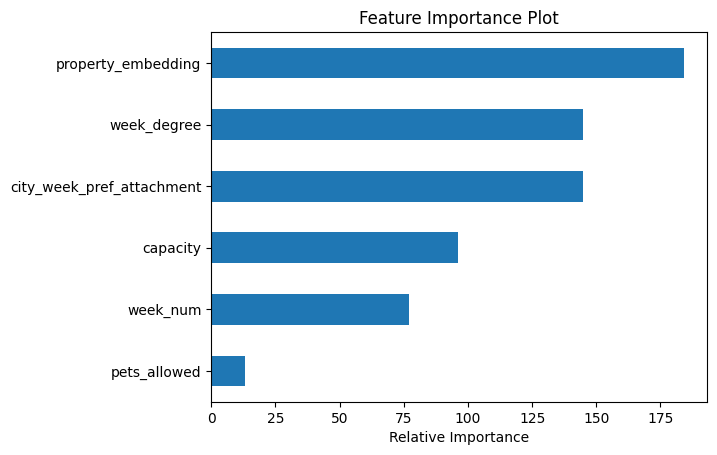

In [43]:
(
    pd.DataFrame(zip(automl.feature_names_in_, automl.feature_importances_), columns=['Feature', 'Importance'])
    .sort_values('Importance', ascending = False)
    .assign(grouped_feature = lambda x: x['Feature'].apply(lambda y: y.split('___')[0]))
    .groupby('grouped_feature')['Importance'].sum().sort_values(ascending = True)
).plot(kind = 'barh', title = 'Feature Importance Plot')
plt.xlabel('Relative Importance')
plt.ylabel('')

In [44]:
# Predict on the test set
y_pred = automl.predict(X_test)

In [45]:
# Create a confusion matrix
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ['Predicted Not Booked', 'Predicted Booked'])
conf_mat.index = ['Actual Not Booked', 'Actual Booked']
conf_mat

,Predicted Not Booked,Predicted Booked
Actual Not Booked,4199,6782
Actual Booked,74,9192


In [46]:
precision_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.5754350820082634, 0.9920138139434491)

: 